In [1]:
import numpy as np
from typing import Union

def apply_power_to_low_ranked_cols(
    p: np.ndarray,
    top_k: int = 30,
    exponent: Union[int, float] = 2,
    inplace: bool = True
) -> np.ndarray:
    """
    Rank columns by their column‑wise maximum and raise every column whose
    rank falls below `top_k` to a given power.

    Parameters
    ----------
    p : np.ndarray
        A 2‑D array of shape **(n_chunks, n_classes)**.

        - **n_chunks** is the number of fixed‑length time chunks obtained
          after slicing the input audio (or other sequential data).  
          *Example:* In the BirdCLEF `test_soundscapes` set, each file is
          60 s long. If you extract non‑overlapping 5 s windows,  
          `n_chunks = 60 s / 5 s = 12`.
        - **n_classes** is the number of classes being predicted.
        - Each element `p[i, j]` is the score or probability of class *j*
          in chunk *i*.

    top_k : int, default=30
        The highest‑ranked columns (by their maximum value) that remain
        unchanged.

    exponent : int or float, default=2
        The power applied to the selected low‑ranked columns  
        (e.g. `2` squares, `0.5` takes the square root, `3` cubes).

    inplace : bool, default=True
        If `True`, modify `p` in place.  
        If `False`, operate on a copy and leave the original array intact.

    Returns
    -------
    np.ndarray
        The transformed array. It is the same object as `p` when
        `inplace=True`; otherwise, it is a new array.

    """
    if not inplace:
        p = p.copy()

    # Identify columns whose max value ranks below `top_k`
    tail_cols = np.argsort(-p.max(axis=0))[top_k:]

    # Apply the power transformation to those columns
    p[:, tail_cols] = p[:, tail_cols] ** exponent
    return p

In [2]:
import os
import gc
import time
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import timm
import torch.nn.functional as F
import torchaudio
import torchaudio.transforms as AT
from contextlib import contextmanager
import concurrent.futures

In [3]:
test_audio_dir = '../input/birdclef-2025/test_soundscapes/'
file_list = [f for f in sorted(os.listdir(test_audio_dir))]
file_list = [file.split('.')[0] for file in file_list if file.endswith('.ogg')]

debug = False
if len(file_list) == 0:
    debug = True
    debug_st_num = 5
    debug_num = 8
    test_audio_dir = '../input/birdclef-2025/train_soundscapes/'
    file_list = [f for f in sorted(os.listdir(test_audio_dir))]
    file_list = [file.split('.')[0] for file in file_list if file.endswith('.ogg')]
    file_list = file_list[debug_st_num:debug_st_num+debug_num]

print('Debug mode:', debug)
print('Number of test soundscapes:', len(file_list))

Debug mode: True
Number of test soundscapes: 8


In [4]:
wav_sec = 5
sample_rate = 32000
min_segment = sample_rate*wav_sec

class_labels = sorted(os.listdir('../input/birdclef-2025/train_audio/'))

n_fft=1024
win_length=1024
hop_length=512
f_min=50
f_max=16000
n_mels=128

mel_spectrogram = AT.MelSpectrogram(
    sample_rate=sample_rate,
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    f_min=f_min,
    f_max=f_max,
    pad_mode="reflect",
    power=2.0,
    norm='slaney',
    n_mels=n_mels,
    mel_scale="htk",
    # normalized=True
)

def normalize_std(spec, eps=1e-6):
    mean = torch.mean(spec)
    std = torch.std(spec)
    return torch.where(std == 0, spec-mean, (spec - mean) / (std+eps))

def audio_to_mel(filepath=None):
    waveform, sample_rate = torchaudio.load(filepath,backend="soundfile")
    len_wav = waveform.shape[1]
    waveform = waveform[0,:].reshape(1, len_wav) # stereo->mono mono->mono
    PREDS = []
    for i in range(12):
        waveform2 = waveform[:,i*sample_rate*5:i*sample_rate*5+sample_rate*5]
        melspec = mel_spectrogram(waveform2)
        melspec = torch.log(melspec+1e-6)
        melspec = normalize_std(melspec)
        melspec = torch.unsqueeze(melspec, dim=0)
        
        PREDS.append(melspec)
    return torch.vstack(PREDS)

In [5]:
def init_layer(layer):
    nn.init.xavier_uniform_(layer.weight)
    if hasattr(layer, "bias"):
        if layer.bias is not None:
            layer.bias.data.fill_(0.)


def init_bn(bn):
    bn.bias.data.fill_(0.)
    bn.weight.data.fill_(1.0)


def init_weights(model):
    classname = model.__class__.__name__
    if classname.find("Conv2d") != -1:
        nn.init.xavier_uniform_(model.weight, gain=np.sqrt(2))
        model.bias.data.fill_(0)
    elif classname.find("BatchNorm") != -1:
        model.weight.data.normal_(1.0, 0.02)
        model.bias.data.fill_(0)
    elif classname.find("GRU") != -1:
        for weight in model.parameters():
            if len(weight.size()) > 1:
                nn.init.orghogonal_(weight.data)
    elif classname.find("Linear") != -1:
        model.weight.data.normal_(0, 0.01)
        model.bias.data.zero_()


def interpolate(x, ratio):
    (batch_size, time_steps, classes_num) = x.shape
    upsampled = x[:, :, None, :].repeat(1, 1, ratio, 1)
    upsampled = upsampled.reshape(batch_size, time_steps * ratio, classes_num)
    return upsampled


def pad_framewise_output(framewise_output, frames_num):
    output = F.interpolate(
        framewise_output.unsqueeze(1),
        size=(frames_num, framewise_output.size(2)),
        align_corners=True,
        mode="bilinear").squeeze(1)

    return output


class AttBlockV2(nn.Module):
    def __init__(self,
                 in_features: int,
                 out_features: int,
                 activation="linear"):
        super().__init__()

        self.activation = activation
        self.att = nn.Conv1d(
            in_channels=in_features,
            out_channels=out_features,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=True)
        self.cla = nn.Conv1d(
            in_channels=in_features,
            out_channels=out_features,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=True)

        self.init_weights()

    def init_weights(self):
        init_layer(self.att)
        init_layer(self.cla)

    def forward(self, x):
        norm_att = torch.softmax(torch.tanh(self.att(x)), dim=-1)
        cla = self.nonlinear_transform(self.cla(x))
        x = torch.sum(norm_att * cla, dim=2)
        return x, norm_att, cla

    def nonlinear_transform(self, x):
        if self.activation == 'linear':
            return x
        elif self.activation == 'sigmoid':
            return torch.sigmoid(x)


class TimmSED(nn.Module):
    def __init__(self, base_model_name: str, pretrained=False, num_classes=24, in_channels=1, n_mels=24):
        super().__init__()

        self.bn0 = nn.BatchNorm2d(n_mels)

        base_model = timm.create_model(
            base_model_name, pretrained=pretrained, in_chans=in_channels)
        layers = list(base_model.children())[:-2]
        self.encoder = nn.Sequential(*layers)

        in_features = base_model.num_features

        self.fc1 = nn.Linear(in_features, in_features, bias=True)
        self.att_block2 = AttBlockV2(
            in_features, num_classes, activation="sigmoid")

        self.init_weight()

    def init_weight(self):
        init_bn(self.bn0)
        init_layer(self.fc1)
        

    def forward(self, input_data):
        x = input_data.transpose(2,3)
        x = torch.cat((x,x,x),1)

        x = x.transpose(2, 3)

        x = self.encoder(x)
        
        x = torch.mean(x, dim=2)

        x1 = F.max_pool1d(x, kernel_size=3, stride=1, padding=1)
        x2 = F.avg_pool1d(x, kernel_size=3, stride=1, padding=1)
        x = x1 + x2

        x = x.transpose(1, 2)
        x = F.relu_(self.fc1(x))
        x = x.transpose(1, 2)

        (clipwise_output, norm_att, segmentwise_output) = self.att_block2(x)
        logit = torch.sum(norm_att * self.att_block2.cla(x), dim=2)

        output_dict = {
            'logit': logit,
        }

        return output_dict

In [6]:
base_model_name='eca_nfnet_l0'
pretrained=False
in_channels=3

MODELS = [f'/kaggle/input/birdclef-2025-sed-models-p/sed{i}.pth' for i in range(3)]

MODELS

['/kaggle/input/birdclef-2025-sed-models-p/sed0.pth',
 '/kaggle/input/birdclef-2025-sed-models-p/sed1.pth',
 '/kaggle/input/birdclef-2025-sed-models-p/sed2.pth']

In [7]:
models = []
for path in MODELS:
    model = TimmSED(base_model_name=base_model_name,
               pretrained=pretrained,
               num_classes=len(class_labels),
               in_channels=in_channels,
               n_mels=n_mels);
    model.load_state_dict(torch.load(path, weights_only=True, map_location=torch.device('cpu')))
    model.eval();
    models.append(model)

In [8]:
def prediction(afile):    
    global pred
    path = test_audio_dir + afile + '.ogg'
    with torch.inference_mode():
        sig = audio_to_mel(path)
        outputs = None
        for model in models:
            model.eval()
            p = model(sig)
            p = torch.sigmoid(p['logit']).detach().cpu().numpy() 
            p = apply_power_to_low_ranked_cols(p, top_k=30,exponent=2)
            if outputs is None: outputs = p
            else: outputs += p
            
        outputs /= len(models)
        chunks = [[] for i in range(12)]
        for i in range(len(chunks)):        
            chunk_end_time = (i + 1) * 5
            row_id = afile + '_' + str(chunk_end_time)
            pred['row_id'].append(row_id)
            bird_no = 0
            for bird in class_labels:         
                pred[bird].append(outputs[i,bird_no])
                bird_no += 1
        gc.collect()

In [9]:
pred = {'row_id': []}
for species_code in class_labels:
    pred[species_code] = []
    
start = time.time()
with concurrent.futures.ThreadPoolExecutor(max_workers=5) as executor:
    _ = list(executor.map(prediction, file_list))
end_t = time.time()

if debug == True:
    print(700*(end_t - start)/60/debug_num)

31.97223161657651


In [10]:
results = pd.DataFrame(pred, columns = ['row_id'] + class_labels) 
display(results.head())

,row_id,1139490,1192948,1194042,126247,1346504,134933,135045,1462711,1462737,...,yebfly1,yebsee1,yecspi2,yectyr1,yehbla2,yehcar1,yelori1,yeofly1,yercac1,ywcpar
0,H02_20230421_170000_5,0.035089,0.002586,0.006205,0.001981,0.003893,0.007787,0.008193,0.002462,0.132505,...,0.055751,0.006432,0.008950,0.143644,0.005436,0.027411,0.157819,0.084925,0.039610,0.009341
1,H02_20230421_170000_10,0.054115,0.002708,0.006028,0.003147,0.004526,0.009936,0.013162,0.004016,0.153345,...,0.077833,0.022645,0.017388,0.158795,0.008513,0.034197,0.206919,0.147868,0.032723,0.010994
2,H02_20230421_170000_15,0.037706,0.001907,0.009997,0.001917,0.008457,0.003305,0.008255,0.004821,0.169100,...,0.030992,0.006515,0.021095,0.539116,0.002181,0.013197,0.111960,0.112256,0.005482,0.003140
3,H02_20230421_170000_20,0.054006,0.003907,0.002999,0.007543,0.003035,0.004734,0.012504,0.008364,0.226188,...,0.104567,0.010751,0.012915,0.821132,0.003230,0.019693,0.111062,0.112770,0.014433,0.004857
4,H02_20230421_170000_25,0.054059,0.003778,0.005512,0.005328,0.003348,0.005155,0.008494,0.003768,0.166301,...,0.065849,0.011048,0.010977,0.158310,0.007537,0.043684,0.107255,0.164390,0.012017,0.006079


In [11]:
results.to_csv("submission.csv", index=False)    

sub = pd.read_csv('submission.csv')
cols = sub.columns[1:]
groups = sub['row_id'].str.rsplit('_', n=1).str[0]
groups = groups.values
for group in np.unique(groups):
    sub_group = sub[group == groups]
    predictions = sub_group[cols].values
    new_predictions = predictions.copy()
    for i in range(1, predictions.shape[0]-1):
        new_predictions[i] = (predictions[i-1] * 0.2) + (predictions[i] * 0.6) + (predictions[i+1] * 0.2)
    new_predictions[0] = (predictions[0] * 0.8) + (predictions[1] * 0.2)
    new_predictions[-1] = (predictions[-1] * 0.8) + (predictions[-2] * 0.2)
    sub_group[cols] = new_predictions
    sub[group == groups] = sub_group
sub.to_csv("submission.csv", index=False)


if debug:
    display(results)

/tmp/ipykernel_13/252437330.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_group[cols] = new_predictions
/tmp/ipykernel_13/252437330.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_group[cols] = new_predictions
/tmp/ipykernel_13/252437330.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/inde

,row_id,1139490,1192948,1194042,126247,1346504,134933,135045,1462711,1462737,...,yebfly1,yebsee1,yecspi2,yectyr1,yehbla2,yehcar1,yelori1,yeofly1,yercac1,ywcpar
0,H02_20230421_170000_5,0.035089,0.002586,0.006205,0.001981,0.003893,0.007787,0.008193,0.002462,0.132505,...,0.055751,0.006432,0.008950,0.143644,0.005436,0.027411,0.157819,0.084925,0.039610,0.009341
1,H02_20230421_170000_10,0.054115,0.002708,0.006028,0.003147,0.004526,0.009936,0.013162,0.004016,0.153345,...,0.077833,0.022645,0.017388,0.158795,0.008513,0.034197,0.206919,0.147868,0.032723,0.010994
2,H02_20230421_170000_15,0.037706,0.001907,0.009997,0.001917,0.008457,0.003305,0.008255,0.004821,0.169100,...,0.030992,0.006515,0.021095,0.539116,0.002181,0.013197,0.111960,0.112256,0.005482,0.003140
3,H02_20230421_170000_20,0.054006,0.003907,0.002999,0.007543,0.003035,0.004734,0.012504,0.008364,0.226188,...,0.104567,0.010751,0.012915,0.821132,0.003230,0.019693,0.111062,0.112770,0.014433,0.004857
4,H02_20230421_170000_25,0.054059,0.003778,0.005512,0.005328,0.003348,0.005155,0.008494,0.003768,0.166301,...,0.065849,0.011048,0.010977,0.158310,0.007537,0.043684,0.107255,0.164390,0.012017,0.006079
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,H02_20230422_024000_40,0.038412,0.002780,0.057258,0.000536,0.093269,0.021989,0.103223,0.011157,0.126735,...,0.007266,0.023663,0.014562,0.006128,0.001628,0.008734,0.001532,0.134961,0.002643,0.003845
92,H02_20230422_024000_45,0.062791,0.003770,0.165084,0.001353,0.181098,0.026998,0.083232,0.035814,0.302152,...,0.009766,0.025383,0.017281,0.013102,0.000914,0.010504,0.001700,0.148142,0.001599,0.001961
93,H02_20230422_024000_50,0.043049,0.002583,0.049292,0.001153,0.067683,0.032612,0.055733,0.005956,0.205774,...,0.008405,0.039877,0.014352,0.008386,0.001069,0.012168,0.001495,0.144388,0.001792,0.003413
94,H02_20230422_024000_55,0.045305,0.002110,0.048837,0.000979,0.071701,0.035699,0.093621,0.006478,0.174300,...,0.009839,0.031393,0.023468,0.008679,0.001920,0.012624,0.001599,0.151125,0.001720,0.003851


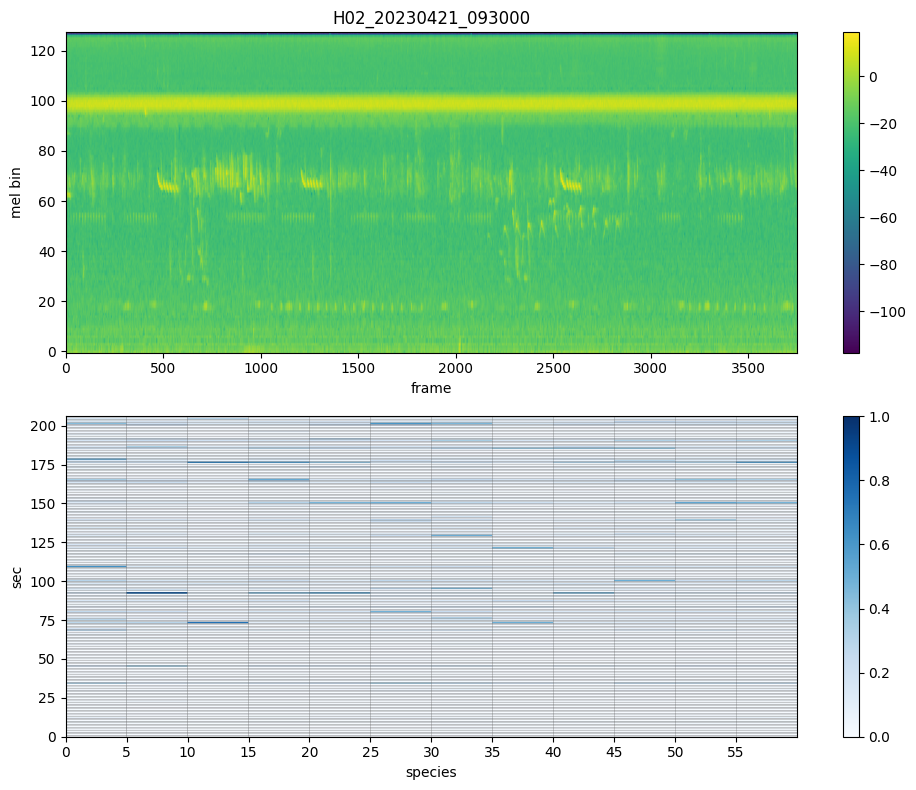

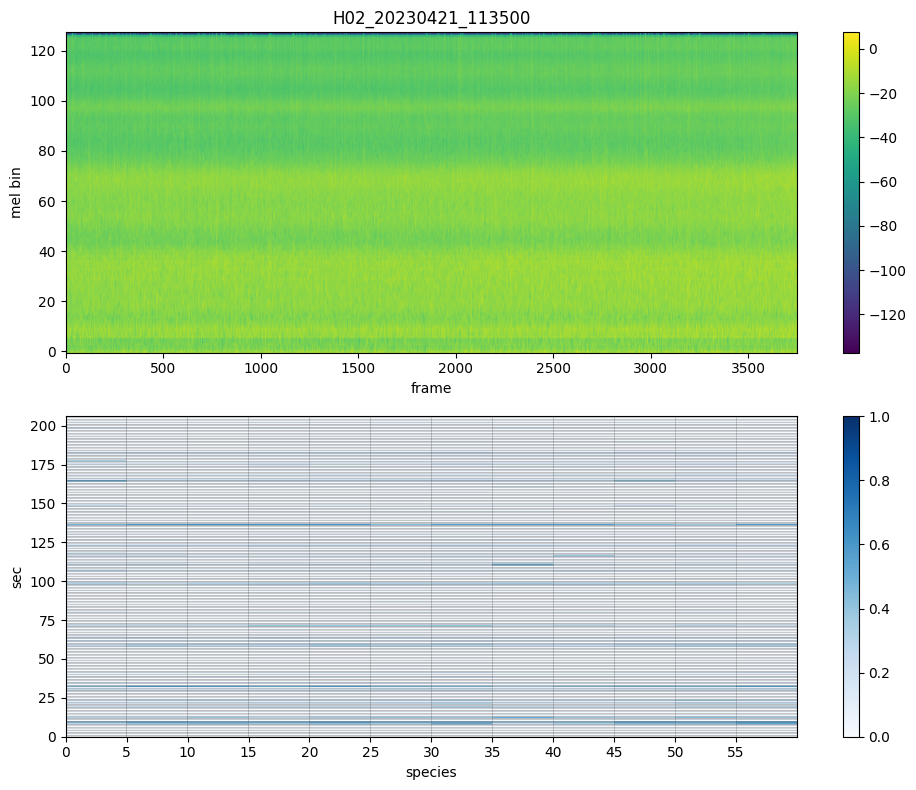

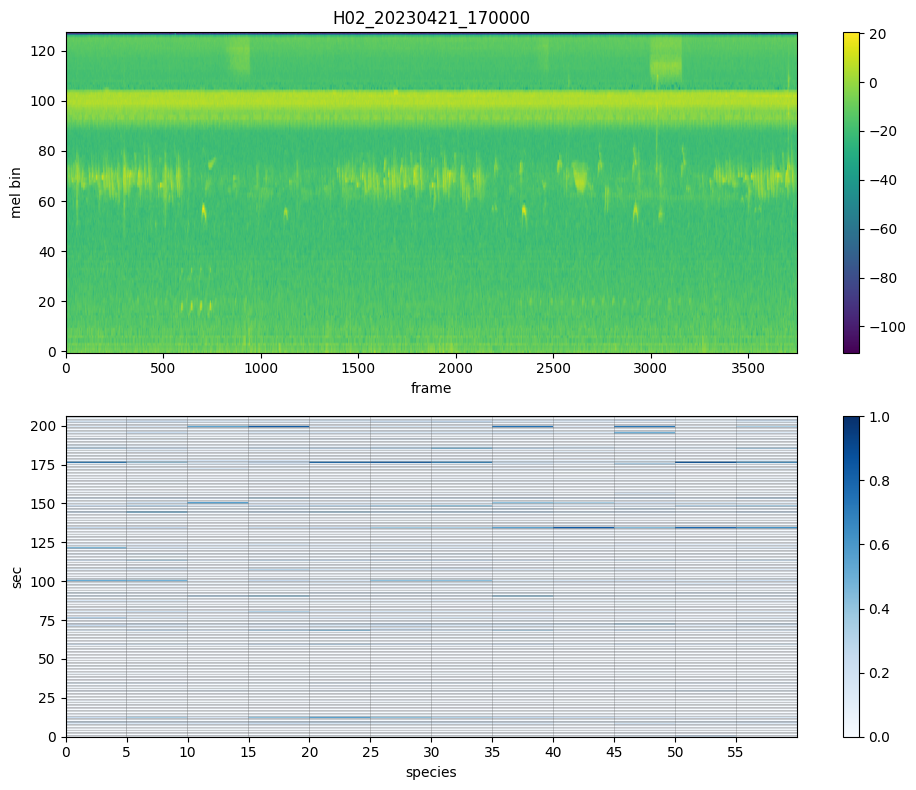

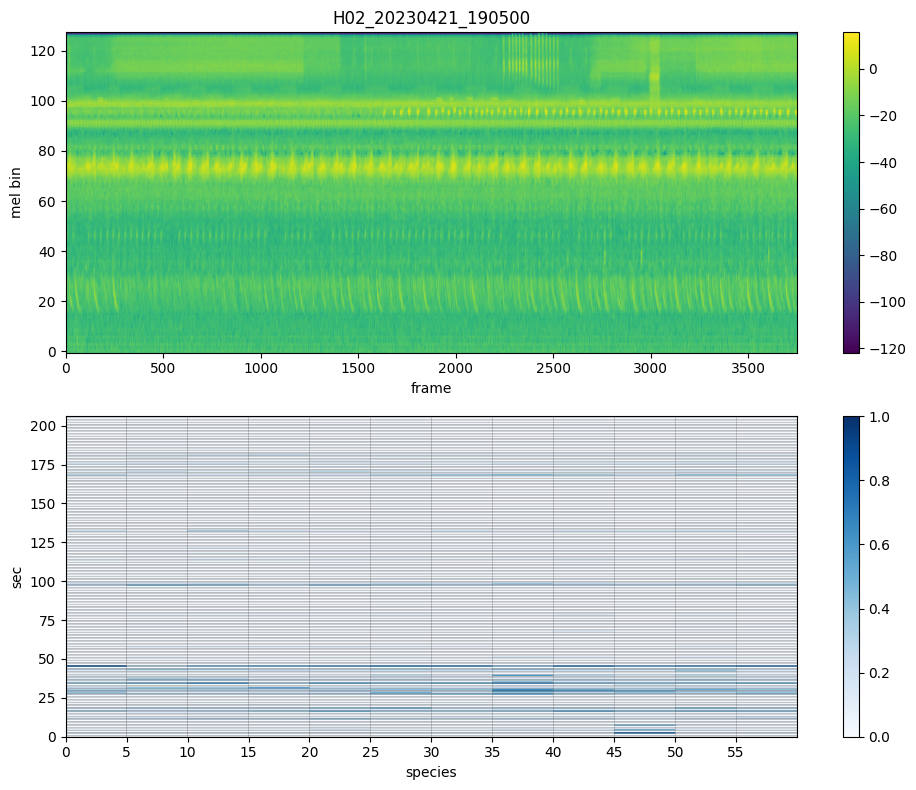

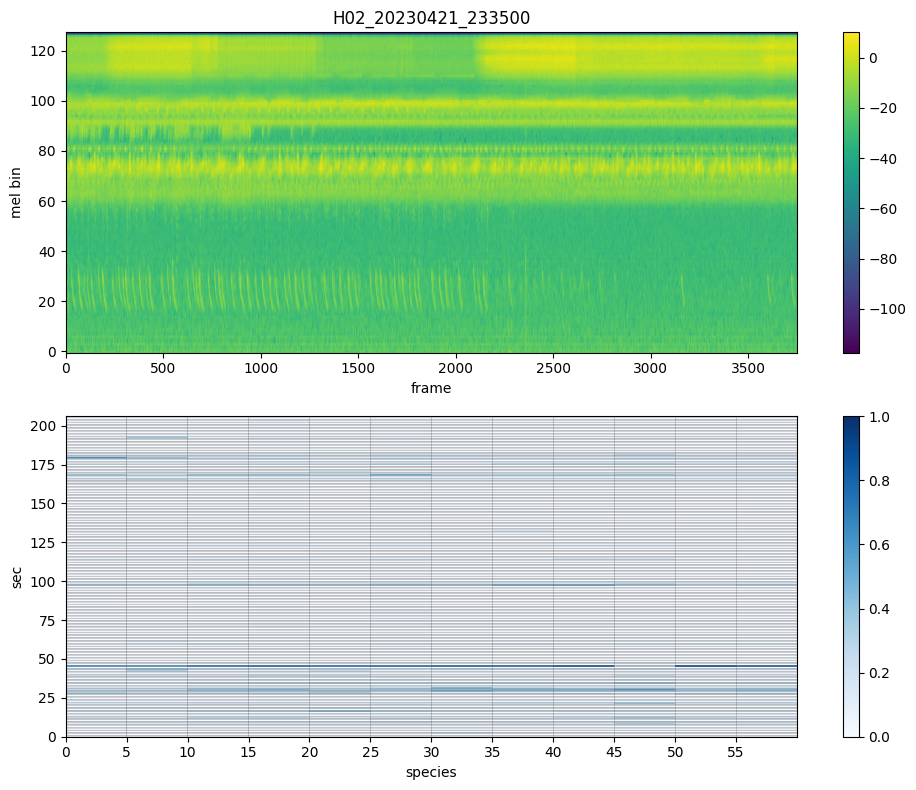

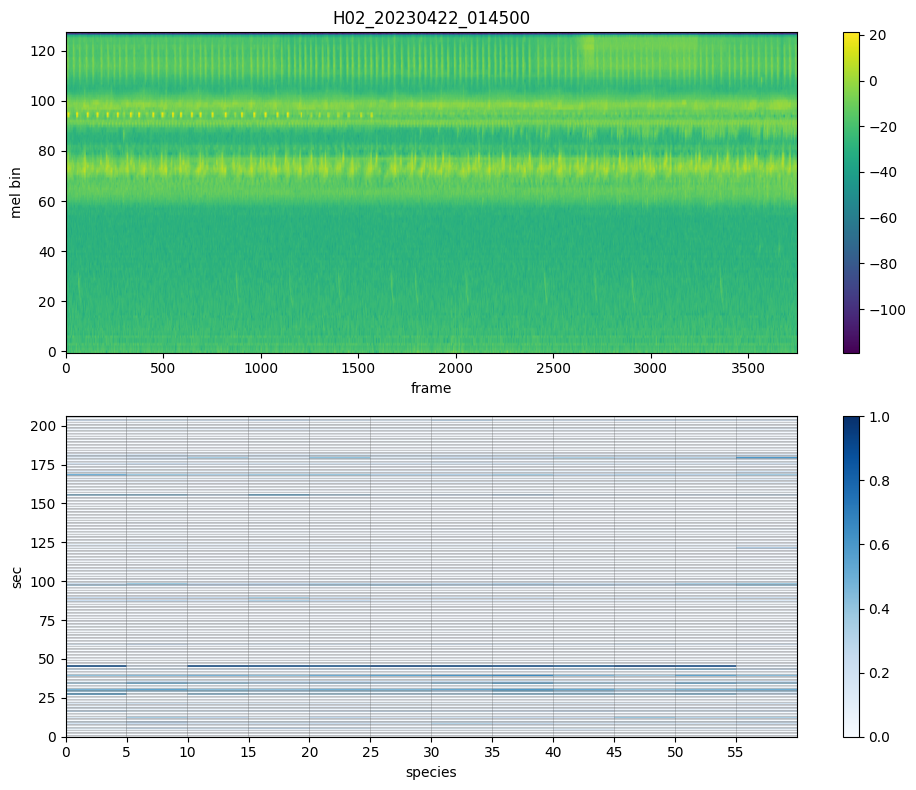

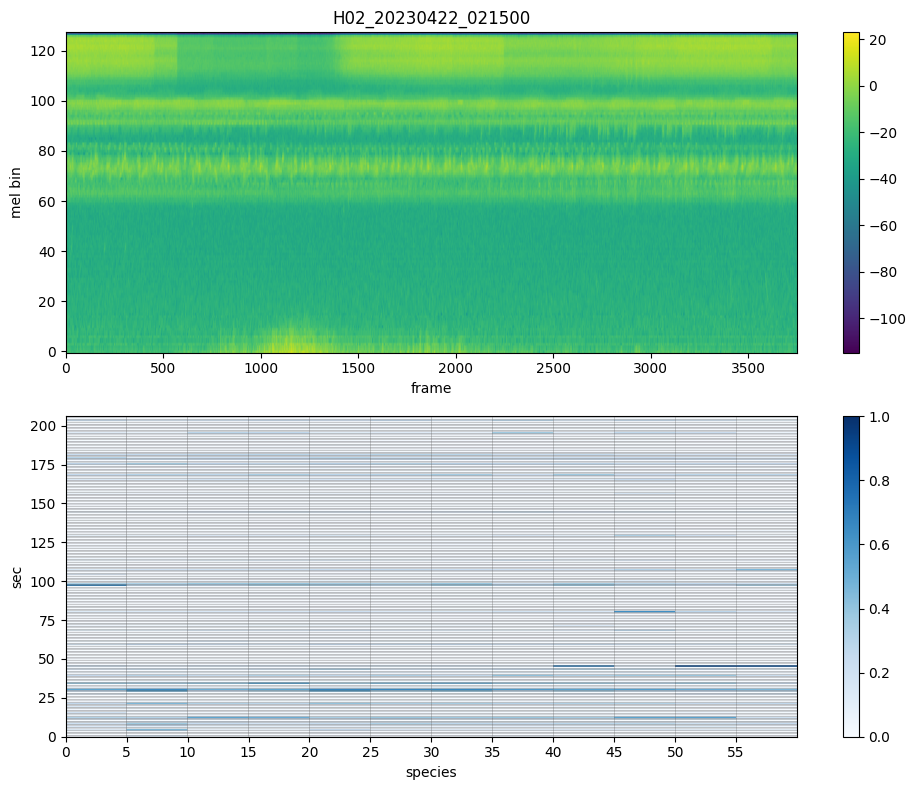

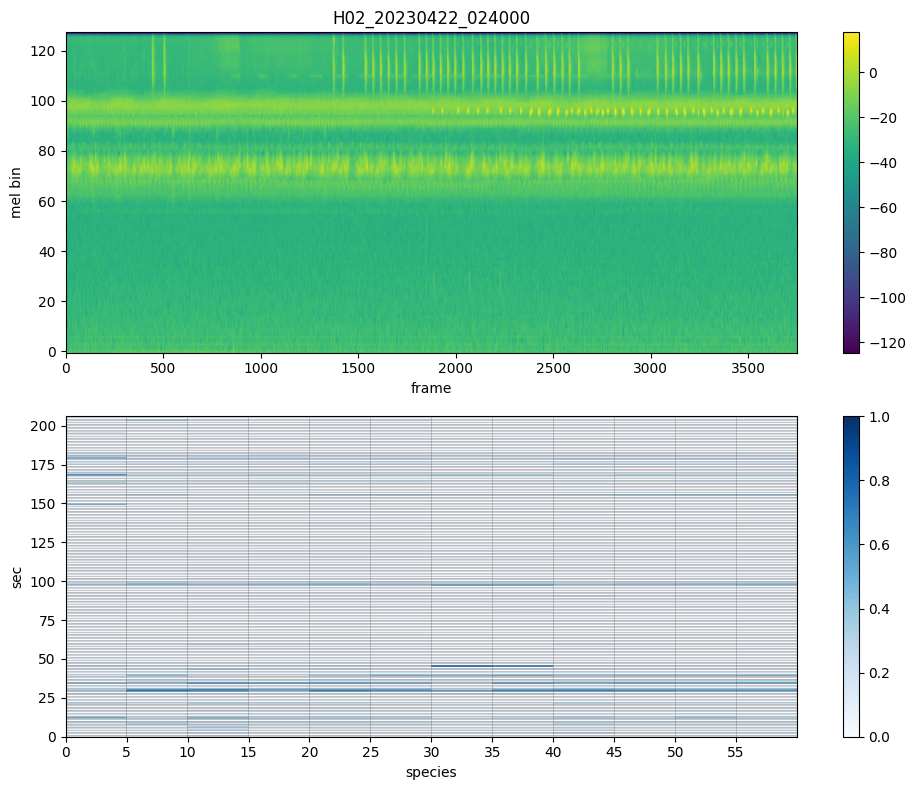

In [12]:
if debug == True:
    import numpy as np
    import matplotlib.pyplot as plt
    
    sample_rate = 32000
    n_fft=1024
    win_length=1024
    hop_length=512
    f_min=50
    f_max=16000
    n_mels=128
    
    mel_spectrogram = AT.MelSpectrogram(
        sample_rate=sample_rate,
        n_fft=n_fft,
        win_length=win_length,
        hop_length=hop_length,
        center=True,
        f_min=f_min,
        f_max=f_max,
        pad_mode="reflect",
        power=2.0,
        norm='slaney',
        n_mels=n_mels,
        mel_scale="htk",
        # normalized=True
    )
    
    def audio_to_mel_debug(filepath=None):
        waveform, sample_rate = torchaudio.load(filepath,backend="soundfile")
        len_wav = waveform.shape[1]
        waveform = waveform / torch.max(torch.abs(waveform))
        melspec = mel_spectrogram(waveform)
        melspec = 10*torch.log10(melspec)
        return melspec
    
    def plot_results(results, file_name):
        path = test_audio_dir + file_name + ".ogg"
        specgram = audio_to_mel_debug(path)
        fig, axes = plt.subplots(2, 1, figsize=(10, 8))
        axes[0].set_title(file_name)
        im = axes[0].imshow((specgram[0]), origin="lower", aspect="auto")
        axes[0].set_ylabel("mel bin")
        axes[0].set_xlabel("frame")
        fig.colorbar(im, ax=axes[0])
        heatmap = axes[1].pcolor(results[results["row_id"].str.contains(file_name)].iloc[:12,1:].values.T, edgecolors='k', linewidths=0.1, vmin=0, vmax=1, cmap='Blues')
        fig.colorbar(heatmap, ax=axes[1])
        axes[1].set_xticks(np.arange(0, 12, 1))
        axes[1].set_xticklabels(np.arange(0,60,5))
        axes[1].set_ylabel("sec")
        axes[1].set_xlabel("species")
        fig.tight_layout()
        fig.show()
        
    for file_name in file_list:
        plot_results(results, file_name)